In [1]:
import pandas as pd
import numpy as np
import math
import re
import random
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Bidirectional
from keras.layers import Dropout
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Soft Computing/Project/updated_dataset.csv')

In [4]:
df.head()

,Unnamed: 0,review,sentiment,target,length
0,4320,film one boring film ever made. thing liked us...,negative,0,591
1,19407,got action fantasy mixed together want action ...,positive,1,189
2,14362,"1955 heist film follows tony le stephanois, re...",positive,1,938
3,5596,one film couple hour sunday morning -- able th...,negative,0,1100
4,14179,im big tim matheson fan admit liked film.it da...,positive,1,565


## Vectorization

In [5]:
dataset = df
unique_label = np.unique(df["target"])
num_classes = len(unique_label)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataset['review'].values, pd.get_dummies(dataset['target']).values, test_size=0.50)

MAX_NB_WORDS = 120811
MAX_SEQUENCE_LENGTH = 2000
EMBEDDING_DIM = 250

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
word_index = tokenizer.word_index
print("found ", len(word_index), " unique tokens")

train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)
pad_train = pad_sequences(train_seq, maxlen=MAX_SEQUENCE_LENGTH)
pad_test = pad_sequences(test_seq, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', pad_train.shape)

print(pad_train.shape,y_train.shape)
print(pad_test.shape,y_test.shape)

found  120811  unique tokens
Shape of data tensor: (25000, 2000)
(25000, 2000) (25000, 2)
(25000, 2000) (25000, 2)


## Model

In [8]:
model_1 = Sequential()
model_1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=pad_train.shape[1]))
model_1.add(SimpleRNN(250, activation= 'relu'))
model_1.add(Dense(2, activation='sigmoid'))


model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
model_1.summary()

epochs = 20
batch_size = 128

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 250)         30202750  
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 250)               125250    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 502       
Total params: 30,328,502
Trainable params: 30,328,502
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model_1.fit(pad_train, y_train, epochs=epochs, batch_size=batch_size,validation_data=(pad_test, y_test))

Epoch 1/20
196/196 [==============================] - 494s 3s/step - loss: 0.5169 - accuracy: 0.8218 - val_loss: 0.5285 - val_accuracy: 0.8092
Epoch 2/20
196/196 [==============================] - 493s 3s/step - loss: 0.4520 - accuracy: 0.8540 - val_loss: 0.4166 - val_accuracy: 0.8616
Epoch 3/20
196/196 [==============================] - 490s 2s/step - loss: 0.3657 - accuracy: 0.8832 - val_loss: 0.3168 - val_accuracy: 0.9044
Epoch 4/20
196/196 [==============================] - 487s 2s/step - loss: 0.2895 - accuracy: 0.9179 - val_loss: 0.2141 - val_accuracy: 0.9388
Epoch 5/20
196/196 [==============================] - 485s 2s/step - loss: 0.1980 - accuracy: 0.9476 - val_loss: 0.1485 - val_accuracy: 0.9708
Epoch 6/20
196/196 [==============================] - 484s 2s/step - loss: 0.1292 - accuracy: 0.9668 - val_loss: 0.0836 - val_accuracy: 0.9812
Epoch 7/20
196/196 [==============================] - 493s 3s/step - loss: 0.0777 - accuracy: 0.9796 - val_loss: 0.0509 - val_accuracy: 0.9896

In [11]:
evaluation = model_1.evaluate(pad_test,y_test)
accuracy = evaluation[1] * 100
print("Accuracy is : ", accuracy)

782/782 [==============================] - 148s 189ms/step - loss: 1.0435 - accuracy: 0.7989
Accuracy is :  79.88799810409546


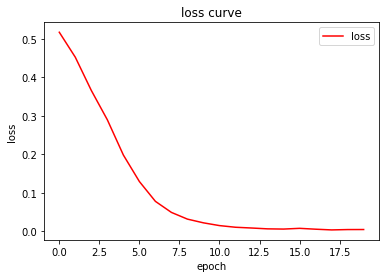

In [27]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], color='r')
# pyplot.plot(history.history['val_loss'], color='b')
pyplot.title('loss curve')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['loss', 'val_loss'], loc='upper right')
pyplot.show()

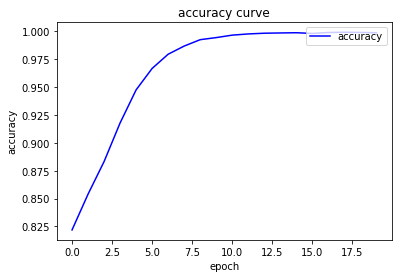

In [13]:
from matplotlib import pyplot

pyplot.plot(history.history['accuracy'], color='b')
# pyplot.plot(history.history['val_accuracy'], color='b')
pyplot.title('accuracy curve')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['accuracy', 'val_accuracy'], loc='upper right')
pyplot.show()

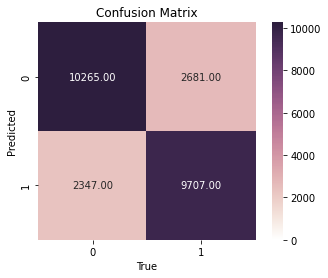

In [14]:
y_pred = model_1.predict(pad_test)

new_y_pred = np.argmax(y_pred, axis=1)
new_y_test = np.argmax(y_test, axis=1)

conf_arr = np.zeros((num_classes, num_classes))

for i in range(len(new_y_pred)):
        conf_arr[new_y_pred[i]][new_y_test[i]] += 1

df_cm = pd.DataFrame(conf_arr, index = unique_label, columns = unique_label)


fig = plt.figure()
plt.clf()

ax = fig.add_subplot()
ax.set_aspect(1)

cmap = sb.cubehelix_palette(light=1, as_cmap=True)
res = sb.heatmap(df_cm, annot=True, vmin=0.0, vmax=np.max(conf_arr), fmt='.2f', cmap=cmap)

plt.title('Confusion Matrix')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()

In [15]:
precision =   precision_score(new_y_test, new_y_pred) * 100
recall =  recall_score(new_y_test, new_y_pred) * 100
f1_score =  f1_score(new_y_test, new_y_pred) * 100
print(precision)
print(f1_score)
print(recall)

80.52928488468558
79.4288519761067
78.35808847271552


In [16]:
print(classification_report(new_y_test, new_y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80     12612
           1       0.81      0.78      0.79     12388

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000



In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score

precision =   precision_score(new_y_test, new_y_pred) * 100
recall =  recall_score(new_y_test, new_y_pred) * 100
f1_score =  f1_score(new_y_test, new_y_pred) * 100
print('Pricision = ',precision)
print('F1_score = ',f1_score)
print('Recall = ',recall)

Pricision =  80.52928488468558
F1_score =  79.4288519761067
Recall =  78.35808847271552


In [18]:
model_1.save('/content/drive/MyDrive/Soft Computing/Project/saved_info/RNN/v1')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Soft Computing/Project/saved_info/RNN/v1/assets


In [19]:
import keras
loaded_model = keras.models.load_model('/content/drive/MyDrive/Soft Computing/Project/saved_info/RNN/v1')

In [23]:
evaluation = loaded_model.evaluate(pad_test,y_test)
accuracy = evaluation[1] * 100
print("Accuracy is : ", accuracy)

782/782 [==============================] - 148s 188ms/step - loss: 1.0435 - accuracy: 0.7989
Accuracy is :  79.88799810409546


In [20]:
np.save('/content/drive/MyDrive/Soft Computing/Project/saved_info/RNN/v1/history.npy',history.history)

In [21]:
h=np.load('/content/drive/MyDrive/Soft Computing/Project/saved_info/RNN/v1/history.npy',allow_pickle='TRUE').item()

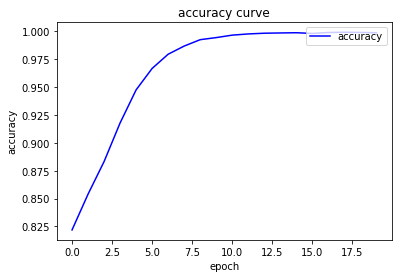

In [25]:
from matplotlib import pyplot

pyplot.plot(h['accuracy'], color='b')
# pyplot.plot(history.history['val_accuracy'], color='b')
pyplot.title('accuracy curve')
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['accuracy', 'val_accuracy'], loc='upper right')
pyplot.show()